# Detecção de fraude - cartão de crédito - Kaggle

## Introdução

Este notebook utiliza base de dados do Kaggle:
- https://www.kaggle.com/mlg-ulb/creditcardfraud

A base de dados contém mais de 284 mil transações de cartão de crédito contendo hora, valor e
28 atributos normalizados obtidos através de transformação PCA de redução de dimensionalidade.
Assim, ao todo são 30 atributos. O alvo do problema é prever se a transação é fraudulenta ou
genuína.
Uma característica fundamental deste dataset e que é comum em sistemas de fraudes é a diferença
entre respostas positivas: 284315 versus respostas negativas fraudulentas: 492. As fraudes 
representam apenas 0,17% das transações.
Este problema pode ser visto como sendo um problema de detecção de anomalia, entretanto iremos
tratá-la como um problema de classificação em duas classes utilizando redes neurais com
várias técnicas de regularização.

## Importação

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 6,526 kB of archives.
After this operation, 14.7 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.0.2 [6,526 kB]
Fetched 6,526 kB in 1s (7,766 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/per

In [2]:
! git lfs clone https://github.com/vcasadei/creditcardfraud.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'creditcardfraud'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), done.


In [3]:
!ls -la creditcardfraud/

total 147312
drwxr-xr-x 3 root root      4096 Jan 19 00:38 .
drwxr-xr-x 1 root root      4096 Jan 19 00:38 ..
-rwxr-xr-x 1 root root 150828752 Jan 19 00:38 creditcard.csv
drwxr-xr-x 9 root root      4096 Jan 19 00:38 .git
-rw-r--r-- 1 root root        42 Jan 19 00:38 .gitattributes


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import os,sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import sklearn.metrics

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Leitura dos dados

In [5]:
dataframe = pd.read_csv('creditcardfraud/creditcard.csv', header=0)
print(dataframe)
print('dataframe.shape:',dataframe.shape)
dataframe.head()

            Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]
dataframe.shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Número de amostras legítimas e fraudulentas

In [6]:
target = np.asarray(dataframe['Class'])
n_samples = target.shape[0]
print('n. de amostras:', n_samples)
print('transações legítimas:', (target==0).sum())
print('transações fraudulentas:', (target==1).sum())

n. de amostras: 284807
transações legítimas: 284315
transações fraudulentas: 492


### Aplica mod no Timestamp para ser uma indicação da hora diária e normaliza dados 

In [7]:
df_cp = dataframe.copy()
inputs = np.asarray(df_cp.values)[:,:-1]
timestamp = inputs[:,0]
timestamp = timestamp % (60* 60 * 24) # modulo número de segundos por dia
inputs -= inputs.min(axis=0)
inputs /= inputs.max(axis=0)
inputs[:1],inputs.shape  # dados de uma amostra normalizada

(array([[0.        , 0.93519234, 0.76649042, 0.8813649 , 0.31302266,
         0.76343873, 0.26766864, 0.26681518, 0.7864442 , 0.47531173,
         0.51060048, 0.25248432, 0.68090763, 0.3715906 , 0.63559053,
         0.4460837 , 0.43439239, 0.73717255, 0.65506586, 0.59486323,
         0.58294223, 0.56118439, 0.52299212, 0.66379298, 0.39125268,
         0.58512179, 0.39455679, 0.41897614, 0.31269663, 0.00582379]]),
 (284807, 30))

### Visualiza com boxplot

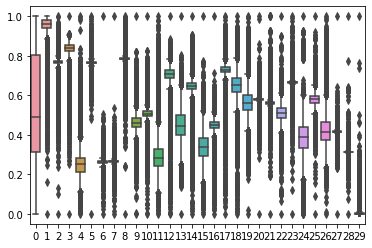

In [8]:
sns.boxplot(data=inputs[:,:]);

## Separação dados em treinamento e teste (20%)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(inputs, target, test_size=0.5, random_state=1)
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

In [10]:
Y_train.shape

torch.Size([142403])

In [11]:
(target==1).sum()

492

In [12]:
FEATURE_NUM = 30
CLASSES = 2

## Definição da rede

In [13]:
# 99.84726659878515%
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 90)
        self.fc5 = nn.Linear(90, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25)
        x = F.sigmoid(self.fc5(x))
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model(
  (fc1): Linear(in_features=30, out_features=90, bias=True)
  (fc5): Linear(in_features=90, out_features=1, bias=True)
)

## Testando um predict

In [14]:
if use_gpu:
    y = model(Variable(X_train[0:3]).cuda())
else:
    y = model(Variable(X_train[0:3]))
print(y)
print(F.softmax(y,dim=1))

tensor([[0.4346],
        [0.4326],
        [0.4261]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Treinamento

In [15]:
loss_fn = nn.BCELoss()
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = torch.flatten(output)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [20]:
num_fraud = (target==1).sum()
num_fraud

492

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(torch.flatten(output), target)
            _, pred = torch.max(output.data, 1)  # get the index of the max log-probability
            total += target.size(0)
            for i in pred:
                if (i == 1):
                    correct += 1
    test_loss /= len(test_loader.dataset)

    print(correct)

    print('\nTest set: Accuracy: {}/{} ({}%)\n'.format(
        correct, len(test_loader.dataset),
        100 * correct/num_fraud))

In [25]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 142403}
test_kwargs = {'batch_size': 142403} # A escolha do batch_size é crítica pois se batch_size for pequeno, só treina com legítimos

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_d = data_utils.TensorDataset(X_train, Y_train)
train_loader = data_utils.DataLoader(train_d, **train_kwargs)

test_d = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test_d, **test_kwargs)


model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 10
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

for epoch in range(1, epochs + 1):
    train(10, False, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_cnn.pt")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f32b61ffc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 1 [0/142403 (0%)]	Loss: 0.800238


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f32b61ffc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


0

Test set: Accuracy: 0/142404 (0.0%)

Train Epoch: 2 [0/142403 (0%)]	Loss: 0.658141
0

Test set: Accuracy: 0/142404 (0.0%)

Train Epoch: 3 [0/142403 (0%)]	Loss: 0.541691
0

Test set: Accuracy: 0/142404 (0.0%)

Train Epoch: 4 [0/142403 (0%)]	Loss: 0.445344


KeyboardInterrupt: ignored

# Atividade

A definição da rede apresentada nesse notebook, produz uma Acurácia de 99,84%. A rede é definida a seguir:


``` python
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(FEATURE_NUM, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 90)
        self.fc5 = nn.Linear(90, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x
```

O seu trabalho é modificar essa rede com o objetivo de conseguir uma acurácia de 99.5% ou mais (para receber **1 (um) ponto** adicional no trabalho do curso). Você pode adicionar ou remover camadas, adicionar ou remover neurônios ou alterar o tipo das camadas de ativação. Só preste atenção para manter a **entrada** como **"FEATURE_NUM"** e a **saída** como **"1"**!

Brinque com o código, tente explorar novas possibilidades e se desafie a resolver o problema com uma rede menos complexa do que a apresentada originalmente!

Para submeter, basta fazer o Download do arquivo notebook e fazer o upload no Classroom.
```
File > Download > Download .ipynb
```

